In [32]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../'))
from collections import defaultdict
import glob
import librosa
from tqdm import tqdm
import numpy as np
import moviepy.editor as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from sklearn.preprocessing import minmax_scale

In [33]:
AUDIO_DIR = f"{sys.path[-1]}/eNTERFACE05_Dataset/*/*/*/*.avi"
CONFIG_FILE = f"{sys.path[-1]}/Audio_Sentiment_Analysis/data/config.json"

In [34]:
config = Configuration.load_json(CONFIG_FILE)

In [35]:
def get_emotion_files(audio_dir) -> defaultdict:
    emotion_data = defaultdict(lambda: defaultdict(list))

    for file_path in glob.glob(audio_dir):
        emotion = file_path.split('/')[-3]

        file_type = file_path.split('.')[-1]

        if file_type == 'avi':
            audio_file_path = file_path[:-3] + 'wav'

            # convert file type to wav
            if not os.path.isfile(audio_file_path):
                audio_clip = mp.VideoFileClip(file_path)
                audio_clip.audio.write_audiofile(audio_file_path)

            file_path = audio_file_path

        emotion_data[emotion]['files'].append(file_path)

    return emotion_data

In [36]:
# get the files corresponding to each emotion
emotion_data = get_emotion_files(AUDIO_DIR)

In [37]:
def display_melspecgram(melspecgram):
    plt.pcolormesh(melspecgram, cmap="magma")
    plt.title("Log-Mel Magnitude Spectrogram")
    plt.ylabel("Log-Mel Bins (mel)")
    plt.xlabel("Time (sample)")
    plt.colorbar()
    plt.show()

In [38]:
def extract_features(signal, sr):
    return [
        librosa.feature.zero_crossing_rate(signal)[0, 0],
        librosa.feature.spectral_centroid(signal)[0, 0],
        librosa.feature.melspectrogram(signal, sr=sr, n_mels=config.n_mels),
        librosa.feature.mfcc(y=signal, sr=sr)
    ]

In [39]:
def process_data(emotion_data):
    for emotion, data in emotion_data.items():
        first_file = True
        for audio_file in tqdm(data['files']):
            signal, sr = librosa.load(audio_file, res_type='kaiser_fast')

            data['features'].append(extract_features(signal, sr))

            if first_file:
                first_file = False
                print(f"Emotion: {emotion}")
                print('Total number of samples: ', signal.shape[0])
                print('Sample rate: ', sr)
                print('Audio Duration (s): ', librosa.get_duration(signal))
                spec = librosa.feature.melspectrogram(signal, sr=sr, n_mels=config.n_mels)
                display_melspecgram(spec)
                mfcc = librosa.feature.mfcc(y=signal, sr=sr)

  0%|          | 0/215 [00:00<?, ?it/s]

Emotion: fear
Total number of samples:  61740
Sample rate:  22050
Audio Duration (s):  2.8


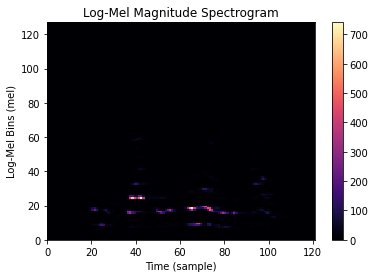

  0%|          | 0/215 [00:00<?, ?it/s]

Emotion: surprise
Total number of samples:  61740
Sample rate:  22050
Audio Duration (s):  2.8


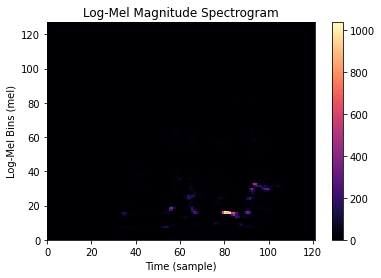

  0%|          | 0/215 [00:00<?, ?it/s]

Emotion: sadness
Total number of samples:  69678
Sample rate:  22050
Audio Duration (s):  3.16


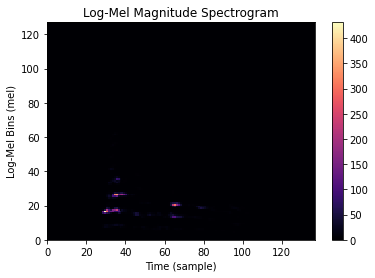

  0%|          | 0/212 [00:00<?, ?it/s]

Emotion: happiness
Total number of samples:  58212
Sample rate:  22050
Audio Duration (s):  2.64


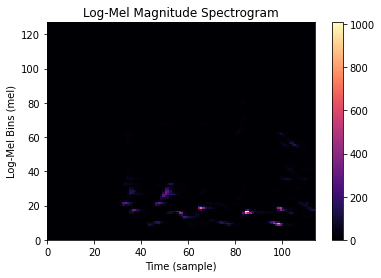

  0%|          | 0/215 [00:00<?, ?it/s]

Emotion: anger
Total number of samples:  85554
Sample rate:  22050
Audio Duration (s):  3.88


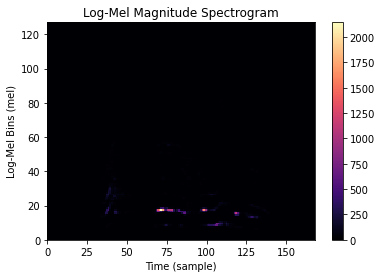

  0%|          | 0/215 [00:00<?, ?it/s]

Emotion: disgust
Total number of samples:  93492
Sample rate:  22050
Audio Duration (s):  4.24


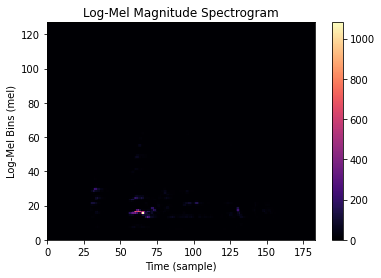

100%|██████████| 215/215 [00:17<00:00, 12.58it/s]


In [40]:
# extract features from audio files
process_data(emotion_data)

In [41]:
def analyse_features(emotion_data):
    zero_cr_means, spect_cent_means = [], []

    for emotion, data in emotion_data.items():
        features = np.array(data['features'])
        cross_rate_values = minmax_scale(features[:,0], config.scale_range)
        spec_cent_values = minmax_scale(features[:,1], config.scale_range)

        # scaling features between 0 and 1
        zero_cr_means.append(np.mean(cross_rate_values))
        spect_cent_means.append(np.mean(spec_cent_values))

    df = pd.DataFrame(zip(list(emotion_data.keys())*6, ["Mean Zero Crossing Rate"]*6+["Mean Spectral Centroid"]*6,\
        zero_cr_means+spect_cent_means), columns=["Emotion", "Mean Values", 'Value'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Emotion", hue="Mean Values", y="Value", data=df)
    plt.show()

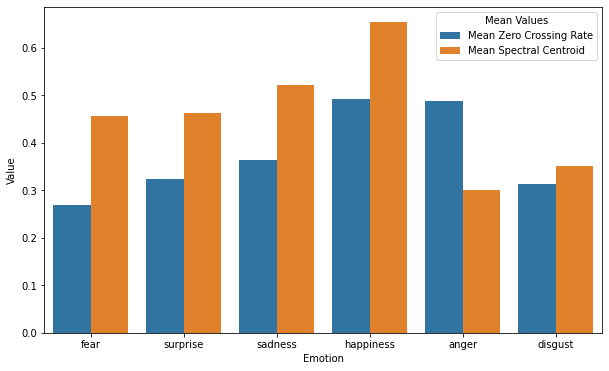

In [42]:
# analyse the extracted features
analyse_features(emotion_data)